# ML-7. Валидация данных и оценка модели
## Юнит 4. Основные алгоритмы машинного обучения. Часть I 
### Skillfactory: DST-10
---
### 7.2. Разбиение выборки
---
Разбиение выборки — это разделение имеющихся данных на несколько частей для проведения процессов обучения и валидации алгоритма МО так, что оба процесса выполнялись на полностью независимых наборах данных.  
Какие бывают выборки:  
*Обучающая* — подмножество данных, на котором мы обучаем модель.  
*Валидационная* — подмножество данных, на котором мы валидируем модель, то есть, проверяем промежуточные результаты. Выборка нужна для проверки модели.  
*Тестовая* — подмножество данных, на котором мы тестируем модель после проверки всевозможных гипотез.  
Обучаем на обучающей выборке: модель явно затачивается под обучающую выборку. Валидируем на валидационной и подкручиваем параметры модели: модель неявно затачивается под валидационную выборку. Тестовая выборка имитирует тестирование модели в реальных условиях.  

Как разбить выборку?  
- сomplete CV — полный скользящий контроль.  В данном случае оценка строится во всем возможным разбиениям. Важно упомянуть этот метод, однако стоит понимать, что даже при малых размерах длины обучающей выборки число выборки очень большое, и это затрудняет практическое применение данного метода. Полный скользящий контроль используют в теоретических исследованиях или в тех случаях (довольно редких), когда удается вывести вычислительную формулу, позволяющую реализовать вычисления. К примеру, для метода k ближайших соседней такая формула известна, но все же этот метод разбиения используется на практике крайне редко.  

- hold-out — отложенная выборка.  Разбиваем выборку на обучающую, валидационную и, по желанию, на тестовую выборки. Обычно в соотношении 60/40 или 70/30, вместе с тестовой — 60/20/20 или 70/15/15. Данный метод чаще всего применяется в случае больших датасетов в силу того, что требует значительно меньше вычислительных мощностей, чем другие методы. Однако важно помнить, что оценка в этом методе сильно зависит от разбиения. Это плохо, так как оценка должна в первую очередь характеризовать сам алгоритм обучения, а не способ разбиения.

- k-fold — cross-validation, перекрёстная валидация. 
  1. Разбиваем выборку на k частей.
  1. Повторяем k раз: обучаем на k-1 частях, валидируем на оставшейся части.
  1. На каждой итерации валидируем на части данных, на которой ещё не валидировали.
  1. Усредняем значения метрики.  

 Позволяет сделать оценку качества более робастной — устойчивой к помехам.
Чаще всего k имеет значение 10 (или 5 в случае маленьких выборок).

- t×k-fold кросс-валидация. Процедура выполняется t раз. Обучающая выборка случайным образом разбивается на k непересекающихся, одинаковых по объему частей. Производится k интераций. На каждой итерации происходит k-fold-разбиение. По сути, такой тип валидации — это k-fold валидация, которая повторяется t раз. Такой способ контроля обладает всеми преимуществами k-fold-валидации, но при этом добавляется возможность увеличивать число разбиений.

- leave-one-out — отложенный пример. Предельный случай k-fold, при котором k равняется размеру всей выборки:
  1. Выбираем пример для валидации, обучаем на всех остальных.
  1. Выбираем пример для валидации, который ещё не видели, возвращаемся в пункт 1.  
  
 Частный случай leave-P-out, при котором нужно перебрать все способы выбора P-элементов из выборки.  Большим недостатком данного метода является то, что он очень ресурсозатратен. Однако нельзя утверждать, что он вообще не используется. В некоторых методах обучения вычисление LOO получается заметно ускорить, и его использование становится возможным.

### 7.3 Разбиение выборки. Практика
---

In [1]:
import pandas as pd
import os
print(os.listdir('./data/'))
PATH_to_file = './data/'

['content_chem_elem_in_diff_types_glass.xls', 'med_params_patients_for_predict_heart_disease.csv', 'params_recording_men_and_women.xls', 'titanic.csv', 'train.csv']


In [2]:

# Воспользуемся встроенным датасетом, который содержит информацию об опухолях груди:
from sklearn.datasets import load_iris # подгружаем датасет
data_iris = load_iris()

# скопируем данные
df_iris = pd.DataFrame(data_iris.data)
# имена столбцов датафрейма задаем, в соответствии с именами переменных:
df_iris.columns = data_iris.feature_names
# добавляем столбец с целевой переменной:
df_iris['target'] = data_iris.target
# для наглядности добавляем столбец с сортами:
df_iris['name'] = df_iris.target.apply(lambda x : data_iris.target_names[x])
# Смотрим, что получилось:
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [3]:
# У нас есть четыре признака, относящиеся к размерам цветка, и классы. На первом этапе мы разобьём выборку на две части: тренировочную и валидационную, а позже рассмотрим, как добавить тестовую. Воспользуемся методом train_test_split() из библиотеки sklearn:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df_iris, test_size=0.15, shuffle=True)
# параметр shuffle = необходимо перемешать

print('Размер исходной выборки: {}\nРазмер тренировочной выборки: {}\nРазмер валидационной выборки: {}'
      .format(df_iris.shape, train.shape, valid.shape)
)

Размер исходной выборки: (150, 6)
Размер тренировочной выборки: (127, 6)
Размер валидационной выборки: (23, 6)


In [4]:
# Теперь визуализируем наше разбиение с помощью специального метода:
from itertools import zip_longest
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

def visualize_train_valid_counts(init_data, d_class, train, valid, test=[]):
    width = 0.2

    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)

    classes = list(init_data[d_class].value_counts().index)
    x = np.array(classes)

    ax.bar(x - width, list(init_data[d_class].value_counts()[classes]*2), width, color='r', label='Исходные данные')
    height_bar1 = [i * 2 for i in list(train[d_class].value_counts()[classes])]
    ax.bar(x, height_bar1, width, color='g', label='Тренировочная выборка')
    height_bar2 = [i * 2 for i in list(valid[d_class].value_counts()[classes])]
    ax.bar(x, height_bar2, width, bottom=height_bar1, color='b', label='Валидационная выборка')
    if len(test) > 0:
        height_bar3 = [i * 2 for i in list(test[d_class].value_counts()[classes])]
        sum_bar1_2 = [sum(i) for i in zip_longest(height_bar1, height_bar2, fillvalue=0)]
        ax.bar(x, height_bar3, width, bottom=sum_bar1_2, color='y', label='Тестовая выборка')

    ax.set_ylim([0, 140])
    plt.xticks(x - width / 2, classes, fontsize=20)
    plt.yticks(fontsize=15)
    plt.ylabel('Процент заполнения', fontsize=20)
    plt.minorticks_on()
    plt.grid(which='major', color='r')
    plt.grid(which='minor', linestyle=':', color='k')
    plt.legend(fontsize=12)

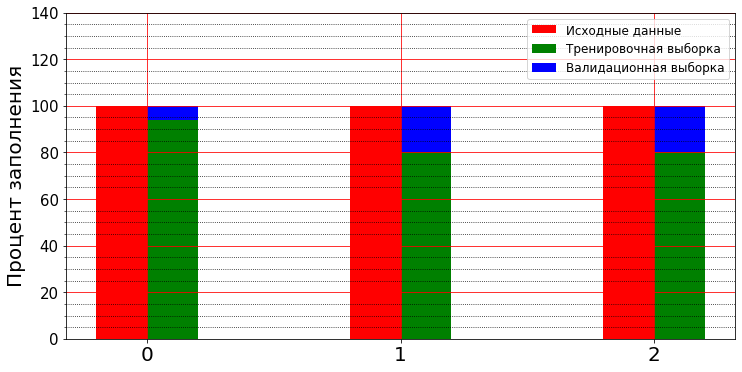

In [5]:
visualize_train_valid_counts(df_iris,'target', train, valid)

У нас три класса цветков, в каждом из которых получилось разное количество примеров с выборками, в третьем примере значительно больше примеров на валидационной выборке. Получилось неравномерное распределение классов после разбиения, так как мы не учли доли классов.

Проблема решается с помощью stratified разбиения или стратифицированного разбиения. В библиотеке sklearn есть нужный нам класс StratifiedShuffleSplit:

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15)
train_indices, valid_indices = [split for split in sss.split(df_iris.iloc[:, :4], df_iris.iloc[:, 4])][0]
s_train = df_iris.iloc[train_indices]
s_valid = df_iris.iloc[valid_indices]

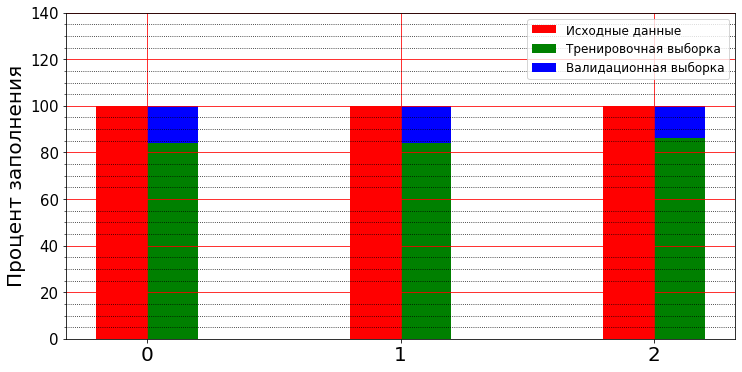

In [7]:
visualize_train_valid_counts(df_iris,'target', s_train, s_valid)

В класс мы передали количество разбиений, размер выборки и вызвали метод split() для более равномерного распределения. В результате разбиение получилось практически одинаковым.

---

Как разбить выборку на три части? Определить размер выборок и поделить дважды: сначала на тренировочную и остальное, затем остальное на валидационную и тестовую:

In [8]:
valid_frac = 0.15
test_frac = 0.15

# также test_size может принимать на вход кол-во необходимых строк
valid_count = int(valid_frac * df_iris.shape[0])
test_count = int(test_frac * df_iris.shape[0])

train, valid_test = train_test_split(df_iris, 
                                     test_size=valid_count+test_count)
valid, test = train_test_split(valid_test, test_size=test_count)

In [9]:
# проверим размерности
df_iris.shape, train.shape, valid_test.shape, valid.shape, test.shape

((150, 6), (106, 6), (44, 6), (22, 6), (22, 6))

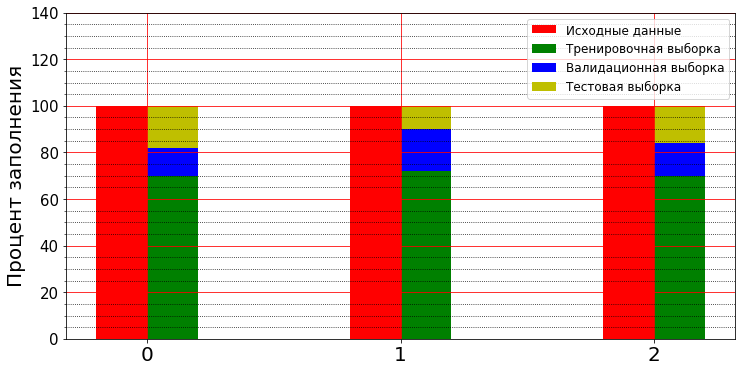

In [10]:
visualize_train_valid_counts(df_iris,'target', train, valid, test)

In [11]:
# пример разбиения на три части с помощью StratifiedShuffleSplit

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.30)
train_indices, valid_test_indices = [split for split in sss2.split(df_iris.iloc[:, :4], df_iris.iloc[:, 4])][0]
s_train = df_iris.iloc[train_indices]
s_valid_test = df_iris.iloc[valid_test_indices]

sss3 = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
train_indices, valid_indices = [split for split in sss3.split(s_valid_test.iloc[:, :4], s_valid_test.iloc[:, 4])][0]
s_valid = s_valid_test.iloc[train_indices]
s_test = s_valid_test.iloc[valid_indices]

In [12]:
# проверим размерности
df_iris.shape, s_train.shape, s_valid_test.shape, s_valid.shape, s_test.shape

((150, 6), (105, 6), (45, 6), (22, 6), (23, 6))

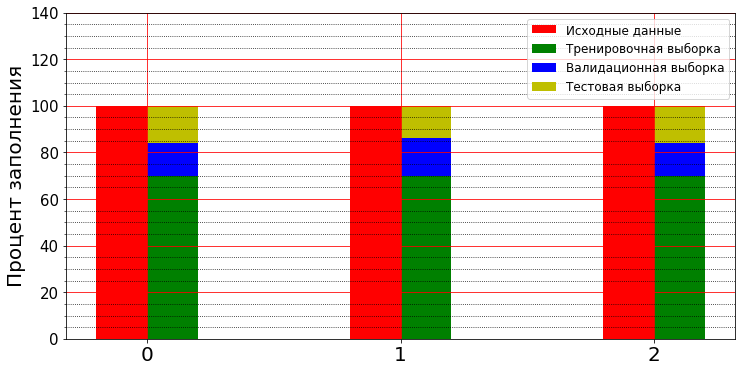

In [13]:
visualize_train_valid_counts(df_iris,'target', s_train, s_valid, s_test)

In [14]:
# Второй тип разбиения — k-fold, перекрёстная валидация. Сделаем k-fold разбиение данных, используя класс KFold:
from sklearn.model_selection import KFold

# shuffle=False исключает предварительное перемешивание примеров
kf = KFold(n_splits=3, shuffle=False)

for train_index, valid_index in kf.split(df_iris):
    print('train indices: {}\nvalid indices: {}'.format(train_index, valid_index))
    print('='*20)

train indices: [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149]
valid indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
train indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 

In [15]:
# Ещё один способ разбиения — leave-one-out, отложенный пример. Сделаем leave-one-out разбиение пяти примерах из исходных данных с помощью класса LeaveOneOut:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

for train_index, valid_index in loo.split(df_iris[:5]):
    print('train indices: {}\nvalid indices: {}'.format(train_index, valid_index))
    print('='*20)

train indices: [1 2 3 4]
valid indices: [0]
train indices: [0 2 3 4]
valid indices: [1]
train indices: [0 1 3 4]
valid indices: [2]
train indices: [0 1 2 4]
valid indices: [3]
train indices: [0 1 2 3]
valid indices: [4]


### Задание 7.3.1
Загрузите данные train.csv, разделите выборку на обучающую и тестовую части в соотношении 70% на 30% без перемешивания. Найдите среднее значение для признака payment_amount и запишите его в переменную result. Обратите внимание, что среднее нужно считать по тестовой выборке.

***Ответ:***
```python
train, test = train_test_split(vis_data, test_size=0.3, shuffle=False)
result = test["payment_amount"].mean()
```

Полный код:  
```python
from sklearn.model_selection import train_test_split
vis_data = pd.read_csv('train.csv', encoding = 'ISO-8859-1')
train, test = train_test_split(vis_data, test_size=0.3, shuffle=False)
result = test["payment_amount"].mean()
```

In [16]:
# проверка кода
from sklearn.model_selection import train_test_split
vis_data = pd.read_csv(PATH_to_file+'train.csv', encoding = 'ISO-8859-1')
train, test = train_test_split(vis_data, test_size=0.3, shuffle=False)
result = test["payment_amount"].mean()

### 7.4. Метрики качества регрессии
---
### Задание 7.4.5
Допустим, у вас есть выборки y_true = \[1.23, 2.35, 2.75\] и y_pred = \[1.01, 12.3, 2.74\]. Посчитайте метрику RMSE, округлите до сотых и запишите результат. Например, 3.14

In [17]:
from sklearn.metrics import mean_squared_error

y_true = np.array([1.23, 2.35, 2.75])
y_pred = np.array([1.01, 12.3, 2.74])

RMSE = mean_squared_error(y_true,y_pred)**0.5
temp = RMSE

task = "7.4.5"
print(f"Ответ к заданию {task}")
print(f"RMSE:= {round(temp,2)}")

Ответ к заданию 7.4.5
RMSE:= 5.75


### 7.5. Метрики качества регрессии. Практика
---
### Задание 7.5.1
Загрузите данные train.csv, оставьте в данных только признаки 'fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due', затем избавьтесь от пропусков. Целевой переменной будет 'balance_due', разделите данные на обучающую и тестовую выборки в соотношении 70% на 30% без перемешивания. Обучите линейную регрессию из scikit-learn и запишите в переменную result значение метрики RMSE на тестовой выборке.

***Ответ:***
```python
df = vis_data[['fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due']]
df.dropna(inplace=True)
X = df[['fine_amount', 'state_fee', 'late_fee', 'discount_amount']]
y = df['balance_due']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
result = mean_squared_error(y_test,y_pred)**0.5
```

Полный код:  
```python
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
vis_data = pd.read_csv('./train.csv', encoding = 'ISO-8859-1', low_memory = False)

df = vis_data[['fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due']]
df.dropna(inplace=True)
X = df[['fine_amount', 'state_fee', 'late_fee', 'discount_amount']]
y = df['balance_due']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
result = mean_squared_error(y_test,y_pred)**0.5
```

In [18]:
# проверка кода
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
vis_data = pd.read_csv(PATH_to_file+'train.csv', encoding = 'ISO-8859-1', low_memory = False)

df = vis_data[['fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due']]
df.dropna(inplace=True)
X = df[['fine_amount', 'state_fee', 'late_fee', 'discount_amount']]
y = df['balance_due']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
result = mean_squared_error(y_test,y_pred)**0.5

### 7.6. Метрики качества классификации
---
### Задание 7.6.7
На этапе вычисления метрик вы получили результаты precision = 0.75 и recall = 0.6. Посчитайте значение метрики $f1$. ***Округлите до сотых и запишите результат.***

In [19]:
precision = 0.75
recall = 0.6

f1 = 2*precision*recall/(precision + recall)
temp = f1

task = "7.6.7"
print(f"Ответ к заданию {task}")
print(f"f1:= {round(temp,2)}")

Ответ к заданию 7.6.7
f1:= 0.67


### Задание 7.6.8
Допустим, у вас есть выборки y_true = \[0, 0, 1, 1, 1, 1, 0, 1\] и y_pred = \[0, 1, 0, 0, 1, 1, 0, 1\]. Посчитайте значение метрики $f1$. ***Округлите до сотых и запишите результат.***

In [20]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_true = [0, 0, 1, 1, 1, 1, 0, 1]
y_pred = [0, 1, 0, 0, 1, 1, 0, 1]

f1 = f1_score(y_true,y_pred)
temp = f1

task = "7.6.8"
print(f"Ответ к заданию {task}")
print(f"f1:= {round(temp,2)}")

Ответ к заданию 7.6.8
f1:= 0.67


### Задание 7.6.9
Допустим, у вас есть выборки y_true = \[0, 0, 1, 0, 0, 1, 0\] и y_pred = \[1, 1, 1, 0, 1, 1, 0\]. Посчитайте значение метрики $precision$. ***Округлите до сотых и запишите результат.***

In [21]:
y_true = [0, 0, 1, 0, 0, 1, 0]
y_pred = [1, 1, 1, 0, 1, 1, 0]

precision = precision_score(y_true,y_pred)
temp = precision

task = "7.6.9"
print(f"Ответ к заданию {task}")
print(f"precision:= {round(temp,2)}")

Ответ к заданию 7.6.9
precision:= 0.4


### Задание 7.6.10
Допустим, у вас есть выборки y_true = \[0, 0, 1, 0, 0, 1, 0\] и y_pred = \[1, 1, 1, 0, 1, 1, 0\]. Посчитайте значение метрики $recall$. ***Округлите до сотых и запишите результат.***

In [22]:
y_true = [0, 0, 1, 0, 0, 1, 0]
y_pred = [1, 1, 1, 0, 1, 1, 0]

recall = recall_score(y_true,y_pred)
temp = recall

task = "7.6.10"
print(f"Ответ к заданию {task}")
print(f"recall:= {round(temp,2)}")

Ответ к заданию 7.6.10
recall:= 1.0


### 7.7. Практика для метрик классификации
---

### Предварительное описание к заданию:
Реализуем бинарную классификацию записей голосов (мужских и женских) на основе характеристик записей их разговоров.  

Описание датасэта - **params_recording_men_and_women** - характеристик записей  разговоров мужчин и женщин:  
1. meanfreq: средняя частота голоса (в кГц)  
2. sd: стандартное отклонение частоты голоса  
3. median: медианная частота (в кГц)  
4. Q25: значение в первом квартиле (в кГц)  
5. Q75: значение в третьем квартиле (в кГц)  
6. IQR: интерквартильный размах (в кГц)  
7. skew: ассиметрия  
8. kurt: эксцесс  
9. sp.ent: спектральная энтропия  
10. sfm: энтропия Винера  
11. mode: мода частоты  
12. centroid: частотный центроид  
13. meanfun: средняя основная частота, измеренная по акустическому сигналу  
14. minfun:  минимальная основная частота, измеренная по акустическому сигналу  
15. maxfun: максимальная основная частота, измеренная в акустическом сигнале  
16. meandom: среднее значение доминирующей частоты, измеренной по акустическому сигналу  
17. mindom: минимум доминирующей частоты, измеренной в акустическом сигнале  
18. maxdom: максимум доминирующей частоты, измеренной в акустическом сигнале  
19. dfrange: диапазон доминантных частот, измеренное на звуковой сигнал  
20. modindx: индекс модуляции голоса  

Попробуйте построить модель, предсказывающую пол обладателя записи голоса.  
Для этого:  
- Разделите выборку на обучающую и тренировочную с параметрами test_size=0.3, random_state=42  
- Нормализуйте признаки с помощью функции StandardScaler(). Для обучающей и тестовой выборки по отдельности!  
- Обучите модель логистической регрессии на подготовленных данных.

### Задание 7.7.1
Вычислите значение метрики  и введите полученное значение $accuracy$. ***Запишите ответ в формате трех знаков после запятой (не округляя).***

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

df = pd.read_csv(PATH_to_file+'params_recording_men_and_women.xls')

# обратите внимание в целевом столбце не числовые значения
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

X = df.drop(columns='label')
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled,y_train)
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_pred, y_test)
temp = accuracy

task = "7.7.1"
print(f"Ответ к заданию {task}")
print(f"accuracy:= {int(temp*1000)/1000}")

Ответ к заданию 7.7.1
accuracy:= 0.973


### Предварительное описание к заданию:  
Теперь познакомимся с новым алгоритмом классификации, а также снова потренируемся делить выборку и осуществлять кросс-валидацию. Кроме того, посмотрим, как можно оценить качество классификации для случая, когда наша классификация не бинарная, т.е. у нас несколько классов.  
В этом кейсе мы попробуем определять типы стекла по его характеристикам.  

Описание датасета - **content_chem_elem_in_diff_types_glass**: в первых столбцах показатели содержания различных веществ в стекле, а в последнем (Type) — непосредственно тип стекла

### Задание 7.7.2
Сколько классов стекла представлено в этой задаче?

In [24]:
df = pd.read_csv(PATH_to_file+'content_chem_elem_in_diff_types_glass.xls')

temp = df['Type'].nunique()

task = "7.7.2"
print(f"Ответ к заданию {task}")
print(f"классов стекла в этой задаче:= {temp} классов")

Ответ к заданию 7.7.2
классов стекла в этой задаче:= 6 классов


Итак, мы выяснили, сколько у нас классов и узнали, что в этот раз у нас будет не бинарная классификация. А значит, мы не сможем использовать некоторые метрики качества (например, $precision$ и $recall$).  
Приступим непосредственно к построению модели. На примере этой задачи мы узнаем новый алгоритм kNN (метод ближайших соседей). Это один из простейших методов классификации.  
Его называют ленивым классификатором, потому что во время обучения модели он ничего не делает, просто считывает и сохраняет тренировочные данные. Сама классификация для него начинается тогда, когда ему дают тестовые данные. Тогда kNN проходит два базовых шага:  
1. Сначала он ищет k ближайших размеченных точек данных – эти точки и называют k ближайшими соседями.  
2. Затем, используя классы соседей, kNN решает, как лучше классифицировать новые данные. 

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold

X = df.drop(columns='Type')
y = df.Type

model=KNeighborsClassifier(n_neighbors=3)
kf = KFold(n_splits=5)
cross_val_score(model, X, y, cv=kf, scoring="accuracy")

array([0.44186047, 0.65116279, 0.3255814 , 0.34883721, 0.07142857])

Если мы посмотрим на результаты классификации, то увидим достаточно большой разброс значений точности, а также в целом невысокие значения.

Это произошло в силу очень маленькой выборки в условиях большого количества классов (6 классов и около 200 наблюдений — крайне мало для получения высокого качества модели). Также плохой результат возможен по причине использования довольно простого алгоритма.

### Задание 7.7.3
Измените количество разбиений на 10. Вычислите среднее значение метрики $accuracy$ по 10 разбиениям и введите ниже, ***округлите до сотых***.

In [26]:
model=KNeighborsClassifier(n_neighbors=3)
kf = KFold(n_splits=10)
cross_val_sc = cross_val_score(model, X, y, cv=kf, scoring="accuracy")

temp = cross_val_sc.mean()

task = "7.7.3"
print(f"Ответ к заданию {task}")
print(f"среднее значение метрики accuracy по 10 разбиениям:= {round(temp,2)}")

Ответ к заданию 7.7.3
среднее значение метрики accuracy по 10 разбиениям:= 0.53


### Предварительное описание к заданию:  
В следующей задаче мы будем диагностировать болезни сердца по различным медицинским параметрам пациентов.   

Избавьтесь от выбросов, чтобы они не ухудшили качество нашей модели. Для того, чтобы избавиться от выбросов, уберите все данные, значения признаков которых отстают от первого или третьего квартиля более, чем на 1.5 межквартильного размаха.

### Задание 7.7.4
Сколько наблюдений осталось после удаления выбросов?

In [27]:
df = pd.read_csv(PATH_to_file+'med_params_patients_for_predict_heart_disease.csv', sep=';')

# функция определения левой и правой границы выбросов
def borders_outliers(d_df, d_column):
    Q1 = d_df[d_column].quantile(0.25)
    Q3 = d_df[d_column].quantile(0.75)
    IQR = Q3 - Q1
    border_left = Q1 - 1.5 * IQR
    border_right = Q3 + 1.5 * IQR
    return border_left,border_right

temp0 = df.shape

for col in df.columns:
    border_left,border_right = borders_outliers(df, col)
    df = df.loc[df[col].between(border_left,border_right)]

temp1 = df.shape

task = "7.7.4"
print(f"Ответ к заданию {task}")
print(f"кол-во строк ПОСЛЕ удаления выбросов:= {temp1[0]}")
print()
print(f"для информации: кол-во строк до удаления выбросов:= {temp0[0]}")

Ответ к заданию 7.7.4
кол-во строк ПОСЛЕ удаления выбросов:= 284

для информации: кол-во строк до удаления выбросов:= 303


### Предварительное описание к заданию:  
Теперь разбейте выборку на тестовую и обучающую с параметрами test_size=0.15, random_state=5.  
Обучите модели логистической регрессии ( c параметром max_iter=1000) и KNN (с количеством соседей, равным 3) на этих данных. Вычислите метрики качества.

### Задание 7.7.5
У какой модели выше значение ROC AUC?

In [28]:
from sklearn.metrics import roc_auc_score

X = df.drop(columns='target')
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5)

model1 = LogisticRegression(max_iter=1000)
model1.fit(X_train, y_train)
y_pred_reg = model1.predict(X_test)

model2 = KNeighborsClassifier(n_neighbors=3)
model2.fit(X_train, y_train)
y_pred_knn = model2.predict(X_test)

roc_auc_Reg = roc_auc_score(y_test, y_pred_reg)
roc_auc_KNN = roc_auc_score(y_test, y_pred_knn)

temp0 = roc_auc_Reg
temp1 = roc_auc_KNN

task = "7.7.5"
print(f"Ответ к заданию {task}")
print(f"roc_auc_Reg:= {temp0}")
print(f"roc_auc_KNN:= {temp1}")
print(f"максимальный roc_auc у Логистической регрессии:= {round(temp0,2)}")

Ответ к заданию 7.7.5
roc_auc_Reg:= 0.7651515151515152
roc_auc_KNN:= 0.6233766233766235
максимальный roc_auc у Логистической регрессии:= 0.77


### Задание 7.7.6
Введите это значение (ROC AUC для лучшего классификатора), ***округлите до сотых.***  
***Ответ:*** - 0.77

### 7.8. Underfitting и overfitting
---
Переобучение (overfitting) — проблема, при которой алгоритм чувствителен к незначительным колебаниям в данных в процессе обучения. Из-за этого алгоритм выучивает обучающий набор данных.  
Недообучение (underfitting) — проблема, при которой алгоритм недостаточно хорошо изучил данные и пропускает важные зависимости между признаками. В случае недообучения мы даже на обучающих данных не можем достичь приемлемых оценок для модели.

### Задание 7.8.9
Часто мы считаем, что данные несбалансированны, если соотношение классов в задаче бинарной классификации равно 10 к 1 или больше. У вас есть выборка, в которой соотношение классов подходит под нижний порог критерия несбалансированности. При этом, у вас в выборке 1460 записей. Сколько при этом в выборке записей класса-меньшинства? Ответ округлите вверх, если это необходимо.

In [29]:
temp = 1460/11

task = "7.8.9"
print(f"Ответ к заданию {task}")
print(f"в выборке записей класса-меньшинства:= {round(temp,0)}")

Ответ к заданию 7.8.9
в выборке записей класса-меньшинства:= 133.0


### 7.9. Underfitting и overfitting. Практика
---
#### Пример обучения
Здесь мы рассмотрим пример обучения дерева решений. В качестве датасета возьмем известный датасет 'A Titanic Probability'

In [30]:
# ниже материалы из ноутбука к скринкасту
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

C:\Users\pc\AppData\Local\Programs\Python\Python37-32\lib\site-packages\IPython\core\interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


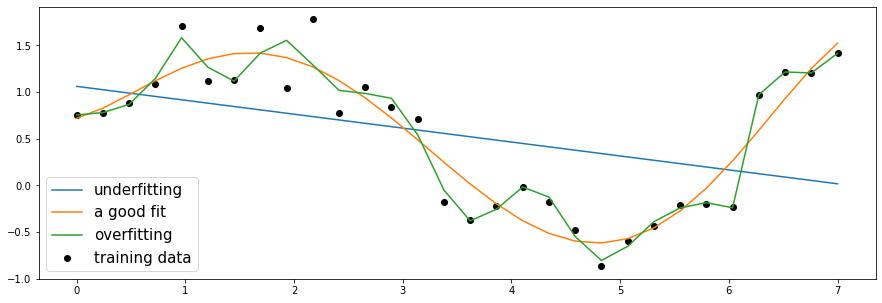

In [31]:
n_points = 30
x = np.linspace(0., 7., n_points)
y = np.sin(x) + np.random.rand(n_points)

plt.figure(figsize=(15, 5))
plt.scatter(x, y, color='k', label='training data')

for degree, label in zip([1, 5, 30], ['underfitting', 'a good fit', 'overfitting']):
    polynomial_coef = np.polyfit(x, y, deg=degree)
    inter_poly = np.polynomial.Polynomial(polynomial_coef[::-1])
    plt.plot(x, inter_poly(x), label=label)
plt.legend(fontsize=15)

In [32]:
from sklearn.tree import DecisionTreeClassifier

titanic = pd.read_csv(PATH_to_file+'titanic.csv')
display(titanic.head(2))

# Заменить категориальный признак "Sex" на два признака "female" и "male" с бинарными значениями
sex_dummies = pd.get_dummies(titanic['Sex'])
titanic = titanic.drop('Sex', axis=1).join(sex_dummies)
# Отбросить имя человека из выборки
titanic = titanic.drop('Name', axis=1)
# Отделим target от признаков
X, y = titanic.iloc[:, 1:], titanic.iloc[:, 0]

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833


#### 7.9.1. Валидация на hold-out выборке

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123)

In [34]:
clf = DecisionTreeClassifier(random_state=456)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=456, splitter='best')

In [35]:
from sklearn.metrics import f1_score
y_pred = clf.predict(X_train)
f1_train = f1_score(y_train, y_pred)
print('[train] F1-score = {:.2f}'.format(f1_train))

[train] F1-score = 0.98


In [36]:
y_pred = clf.predict(X_valid)
f1_val = f1_score(y_valid, y_pred)
print('[valid] F1-score = {:.2f}'.format(f1_val))

[valid] F1-score = 0.71


Как видим, точность при валидации значительно ниже точности при обучении. Проверим это дополнительно с помощью кросс-валидации:

#### 7.9.2. Кросс-валидация
---

In [37]:
from sklearn.model_selection import cross_validate

clf = DecisionTreeClassifier(random_state=456)
cv_metrics = cross_validate(clf, X, y, cv=5, scoring='f1_micro', return_train_score=True)

In [38]:
def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)

[train] F1-score = 0.98 +/- 0.00
[valid] F1-score = 0.78 +/- 0.04


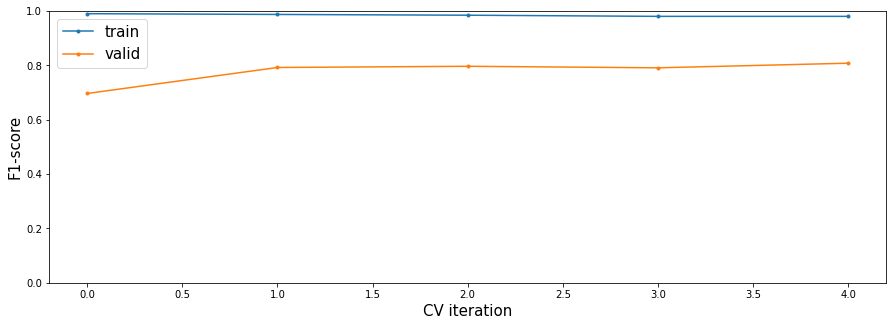

In [39]:
plot_cv_metrics(cv_metrics)

Гипотеза о переобучении подтвердилась. Попробуем избавиться от него, упростив модель — в данном случае ограничим глубину дерева:

[train] F1-score = 0.86 +/- 0.01
[valid] F1-score = 0.83 +/- 0.02


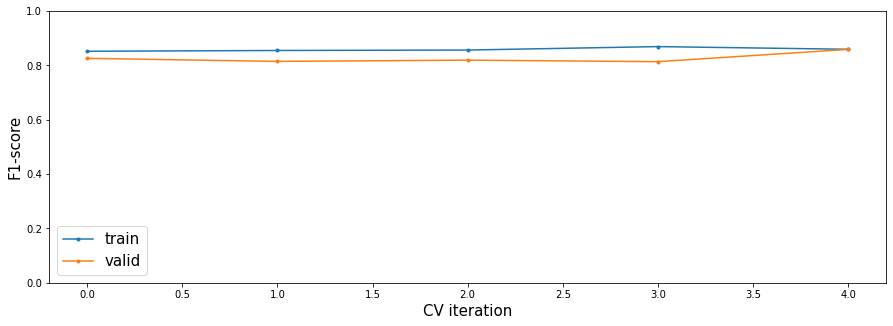

In [40]:
clf = DecisionTreeClassifier(max_depth=5, random_state=456)
cv_metrics = cross_validate(clf, X, y, cv=5, scoring='f1_micro', return_train_score=True)
plot_cv_metrics(cv_metrics)

Итак, метрики при обучении и валидации практически сравнялись, к тому же на валидации значение точности стало выше. Теперь возникает законный вопрос — а можно ли улучшить точность предсказаний? Вполне вероятно, что в данном случае присутствует проблема underfitting. Для ее решения можно заняться созданием новых признаков.

### Задание 7.9.1
Загрузите данные train.csv, оставьте в данных только признаки 'fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due', 'compliance', затем избавьтесь от пропусков.  
Целевой переменной будет 'compliance', разделите данные на обучающую и тестовую выборки в соотношении 70%/30% без перемешивания.  
Обучите DecisionTreeClassifier из scikit-learn с параметром random_state=23. Посчитайте значения метрики $f1$ на тренировочной выборке и на тестовой выборке. Вычтите из значения метрики на тренировочной выборки значение метрики на тестовой выборке и запишите результат в переменную result.

***Ответ:***  
```python
df = vis_data[['fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due', 'compliance']]
df.dropna(inplace=True)
X = df[['fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due']]
y = df['compliance']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=False)

clf = DecisionTreeClassifier(random_state=23)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
f1_train = f1_score(y_train, y_pred)

y_pred = clf.predict(X_valid)
f1_val = f1_score(y_valid, y_pred)

result = f1_train-f1_val
```

Полный код:  
```python
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
vis_data = pd.read_csv("./train.csv", encoding = 'ISO-8859-1', low_memory = False)

df = vis_data[['fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due', 'compliance']]
df.dropna(inplace=True)
X = df[['fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due']]
y = df['compliance']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=False)

clf = DecisionTreeClassifier(random_state=23)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
f1_train = f1_score(y_train, y_pred)

y_pred = clf.predict(X_valid)
f1_val = f1_score(y_valid, y_pred)

result = f1_train-f1_val
```

In [41]:
# проверка  кода

vis_data = pd.read_csv(PATH_to_file+'train.csv', encoding = 'ISO-8859-1', low_memory = False)

df = vis_data[['fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due', 'compliance']]
df.dropna(inplace=True)
X = df[['fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due']]
y = df['compliance']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=False)

clf = DecisionTreeClassifier(random_state=456)
cv_metrics = cross_validate(clf, X, y, cv=5, scoring='f1_micro', return_train_score=True)

y_pred = clf.predict(X_train)
f1_train = f1_score(y_train, y_pred)

y_pred = clf.predict(X_valid)
f1_val = f1_score(y_valid, y_pred)

result = f1_train-f1_val

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Задание 7.9.2
Какой эффект вы обнаружили после обучения?

[train] F1-score = 0.96 +/- 0.00
[valid] F1-score = 0.95 +/- 0.01


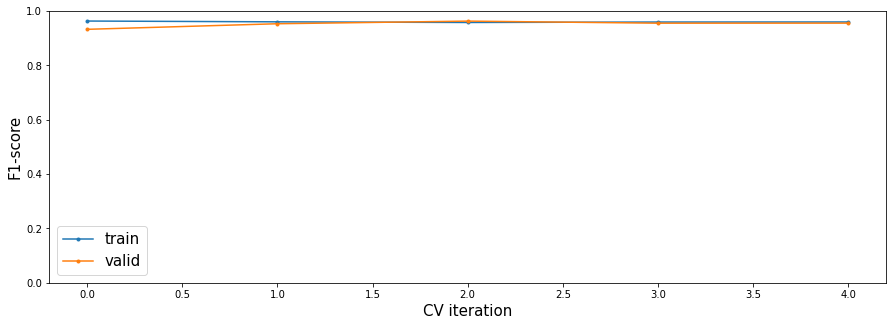

In [42]:
vis_data = pd.read_csv(PATH_to_file+'train.csv', encoding = 'ISO-8859-1', low_memory = False)

df = vis_data[['fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due', 'compliance']]
df.dropna(inplace=True)
X = df[['fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due']]
y = df['compliance']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=23)

clf = DecisionTreeClassifier(max_depth=10, random_state=23)
cv_metrics = cross_validate(clf, X, y, cv=5, scoring='f1_micro', return_train_score=True)

plot_cv_metrics(cv_metrics)

### 7.10. Дисбаланс выборки
---
### 7.11. Дисбаланс выборки. Практика

**Несбалансированная выборка (imbalanced dataset)** — выборка, в которой количество примеров каких-то классов сильно превалирует над количеством примеров других классов. Это определение также можно расширить на другие типы задач. Например, в задаче регрессии дисбалансом выборки будет ситуация, при которой распределение целевых значений будет сильно отличаться от равномерного.

#### 7.11.1. Когда считать выборку несбалансированной?

In [43]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [44]:
titanic = pd.read_csv(PATH_to_file+'titanic.csv')
titanic.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


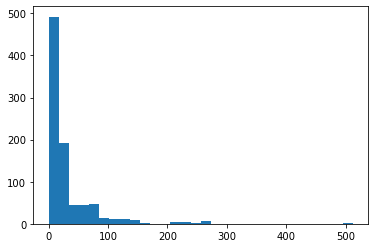

In [45]:
plt.hist(titanic['Fare'], bins=30);

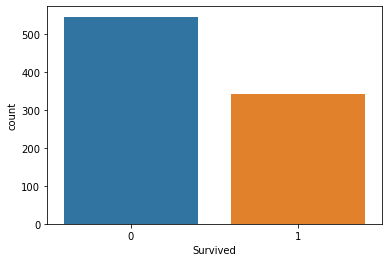

In [46]:
sns.countplot(x='Survived', data=titanic)

Нет точного определения, когда считать выборку несбалансированной. Неформально считается, что выборка несбалансированна, когда отношение количества преобладающего и минорного классов составляет 10:1.

#### 7.11.2. Последствия дисбаланса данных

Что происходит при дисбалансе классов:  
1. У алгоритма появляется склонность к более популярным классам/значениям.  
2. Невозможность использования метрик, не учитывающих веса классов (базовая метрика accuracy, изученная выше, не может быть использована).

### 7.11.3. Решение проблемы

1. Изменить целевую метрику — в задачах классификации confusion matrix, precision, recall, F1-score, ROC-кривые будут намного корректнее описывать алгоритм, чем accuracy.
1. Изменить выборку данных: 1) oversampling — увеличение кол-ва объектов классов-меньшинств; 2) undersampling — сокращение кол-ва объектов превалирующих классов.
1. Добавить штраф в оптимизационный функционал, прямо пропорциональный кол-ву объектов каждого класса (веса классов).
1. Возможно, есть смысл перейти к задачам [Anomaly detection](https://en.wikipedia.org/wiki/Anomaly_detection) и [Change detection](https://en.wikipedia.org/wiki/Change_detection).

Во 2-м способе решение проблемы oversampling может быть выполнено как простым дублированием примеров меньшего класса, так и и более сложной техникой, называемой "аугментацией выборки".

**Аугментация выборки (data augmentation)** — процесс генерации примеров из исходных путем их модификации. Примерами аугментации данных могут служить: повороты, масштабирование изображений, применение фильтров; для текста может быть незначительно изменен контекст и изменено склонение/спряжение слов.

Еще одна техника, которая может быть использована для oversampling это **обогащение данных**. При использовании этой техники данные находятся во внешних дополнительных источниках. Например, если банк решает свою скоринговую задачу, он может также расширить свой набор данных данными другого банка при их наличии.

### Задание 7.11.1
1. Загрузите данные train.csv, оставьте в данных только признаки 'fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due', 'compliance', затем избавьтесь от пропусков.  
2. Обучим модель на несбалансированных данных. Целевой переменной будет 'compliance', разделите данные на обучающую и тестовую выборки в соотношении 70%/30% без перемешивания.  
3. Обучите DecisionTreeClassifier из scikit-learn с параметром random_state=23. Посчитайте значения метрики  на тренировочной выборке и на тестовой выборке.  
4. Затем сделайте эту же выборку сбалансированной с помощью undersampling.  
Для этого посчитайте количество примеров (n) класса-меньшинства, затем из класса-большинства возьмите n первых примеров.  

То есть, в терминологии Python:  
- возьмите срез (slice) от начала и до n, где n — количество примеров класса, которого в выборке представлено меньше.  
- cоедините две части выборки (с уменьшенным классом-большинством и с изначальным классом-меньшинством),   
- сделайте точно такое же разбиение, как в задаче выше, и обучите такую же модель.  

Посчитайте значение метрики  на новой тестовой выборке с помощью новой модели. Вычтите из значения метрики на тестовой части сбалансированной выборки значение метрики на тестовой части несбалансированной выборки и запишите результат в переменную result.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score

vis_data = pd.read_csv(PATH_to_file+'train.csv', encoding = 'ISO-8859-1')

columns = ['fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due', 'compliance']
df = vis_data[columns]
df.dropna(inplace=True)

X = df.drop(columns='compliance')
y = df.compliance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

model = DecisionTreeClassifier(random_state=23)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
f1_full_test = f1_score(y_test, y_pred_test)
f1_full_train = f1_score(y_train, y_pred_train)

n = sum(df.compliance == 1)
compliance0 = df[df.compliance == 0][:n]
compliance1 = df[df.compliance == 1]
df1 = compliance0.append(compliance1)

X1 = df1.drop(columns='compliance')
y1 = df1.compliance

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, shuffle=False)

model = DecisionTreeClassifier(random_state=23)
model.fit(X1_train, y1_train)

y1_pred_test = model.predict(X1_test)
y1_pred_train = model.predict(X1_train)
f1_bal_test = f1_score(y1_test, y1_pred_test)
f1_bal_train = f1_score(y1_train, y1_pred_train)
result = f1_bal_test - f1_full_test

In [ ]:
# Решение от автора курса:
vis_data_small = vis_data[['fine_amount', 'state_fee', 'late_fee', 
                           'discount_amount', 'balance_due', 'compliance']].dropna()
X = vis_data_small[['fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due']]
y = vis_data_small['compliance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
clf = DecisionTreeClassifier(random_state=23)
clf.fit(X_train, y_train)
f1_imbalanced = f1_score(y_test, clf.predict(X_test))

zeros = y[y == 0.0]
ones = y[y == 1.0]
down_index = list(zeros.index[:len(ones)]) + list(ones.index)
X_down = X.ix[down_index, :]
y_down = y[down_index]
X_train, X_test, y_train, y_test = train_test_split(X_down, y_down, test_size=0.3, shuffle=False)
clf = DecisionTreeClassifier(random_state=23)
clf.fit(X_train, y_train)
f1_balanced = f1_score(y_test, clf.predict(X_test))

result = f1_balanced - f1_imbalanced   

### 7.12. Визуализация процесса обучения
---
### 7.13. Готовимся к собеседованию

конец модуля